In [64]:
from time import ctime, time

import matplotlib.pyplot as plt
import numpy as np
from numba import njit, prange
from scipy.sparse.csgraph import laplacian

from graph_optimization import fdla_weights_symmetric

In [65]:
def generateP(A, kappa):
	dmax = np.max(np.sum(A, axis=0))
	L = laplacian(A, normed=False)
	M, _ = np.shape(A)
	I = np.eye(M)

	P = I - (kappa/dmax) * L

	# print rho
	l = np.absolute(np.linalg.eigvals(P))
	l = l[1 - l > 1e-5]
	print(f'kappa: {kappa}, rho: {np.max(l)}')

	print(P)

	return P

In [66]:
# @njit
def run(runs: int, N: int, T: int, trueMeans: np.ndarray, P: np.ndarray) -> tuple:
	'''
	Plays coopucb2 given the number of runs, number of arms, timesteps, true
	means of arms, and the P matrix of the network. Optimized to work with
	numba.
	'''
	sigma_g = 1		# try 10
	# eta = 2		# try 2, 2.2, 3.2
	gamma = 2.0 	# try 1.9, 2.9
	f = lambda t : np.sqrt(np.log(t))
	Geta = 2.0		# try 1 - (eta ** 2)/16
	var = 1.0		# variance for the gaussian distribution behind each arm
	M, _ = P.shape

	reg = np.zeros((runs, M, T))
	Q = np.zeros((runs, M, N, T))	# estimated reward
	plotQ = np.zeros((runs, M, N, T))
	plotExplore = np.zeros((runs, M, N, T))

	n = np.zeros((runs, M, N))	# number of times an arm has been selected by each agent
	s = np.zeros((runs, M, N))	# cumulative expected reward
	xsi = np.zeros((runs, M, N))	# number of times that arm has been selected in that timestep
	rew = np.zeros((runs, M, N))	# reward

	# run coop-ucb2 "runs" number of times
	for run in prange(runs):
		# print(f'run {run}')
		bestArm = np.max(trueMeans[run])

		for t in range(T):
			if t < N:
				for k in range(M):
					rew[run, k] = np.zeros(N)
					xsi[run, k] = np.zeros(N)
					action = t
					rew[run, k, action] = np.random.normal(trueMeans[run, action], var)
					reg[run, k, t] = bestArm - trueMeans[run, action]
					xsi[run, k, action] += 1
			else:
				for k in range(M):
					for i in range(N):
						# Q[k, i, t] = (s[k, i] / n[k, i]) + sigma_g * (np.sqrt((2 * gamma / Geta) * ((n[k, i] + f(t - 1)) / (M * n[k, i])) * (np.log(t - 1) / n[k, i])))
						x0 = s[run, k, i] / n[run, k, i]
						x1 = 2 * gamma / Geta
						x2 = (n[run, k, i] + f(t - 1)) / (M * n[run, k, i])
						x3 = np.log(t - 1) / n[run, k, i]
						Q[run, k, i, t] = x0 + sigma_g * np.sqrt(x1 * x2 * x3)
						plotQ[run, k, i, t] = x0
						plotExplore[run, k, i, t] = sigma_g * np.sqrt(x1 * x2 * x3)

					rew[run, k] = np.zeros(N)
					xsi[run, k] = np.zeros(N)

					action = np.argmax(Q[run, k, :, t])
					rew[run, k, action] = np.random.normal(trueMeans[run, action], var)
					reg[run, k, t] = bestArm - trueMeans[run, action]
					xsi[run, k, action] += 1

			# update estimates using running consensus
			for i in range(N):
				n[run, :, i] = P @ (n[run, :, i] + xsi[run, :, i])
				s[run, :, i] = P @ (s[run, :, i] + rew[run, :, i])

			# print(f'n{t}', n)
			# print(f's{t}', s)
			# print(f'xsi{t}', xsi)
			# print(f'exp{t}', plotExplore[:, :, t])
			# print(f'Q{t}', Q[:, :, t])

	print(n)
	return reg, Q, plotQ, plotExplore

Simulation started at Tue Nov  8 11:27:37 2022
kappa: 0.02, rho: 0.9750000000000001
[[0.98  0.005 0.005 0.005 0.005]
 [0.005 0.98  0.005 0.005 0.005]
 [0.005 0.005 0.98  0.005 0.005]
 [0.005 0.005 0.005 0.98  0.005]
 [0.005 0.005 0.005 0.005 0.98 ]]
[[[495.99932973   2.60066807   1.4000022 ]
  [495.99990299   2.60009841   1.39999859]
  [496.00065346   2.59934452   1.40000202]
  [495.99946082   2.60054059   1.39999859]
  [496.000653     2.59934841   1.39999859]]]
Simulation ended at Tue Nov  8 11:27:37 2022


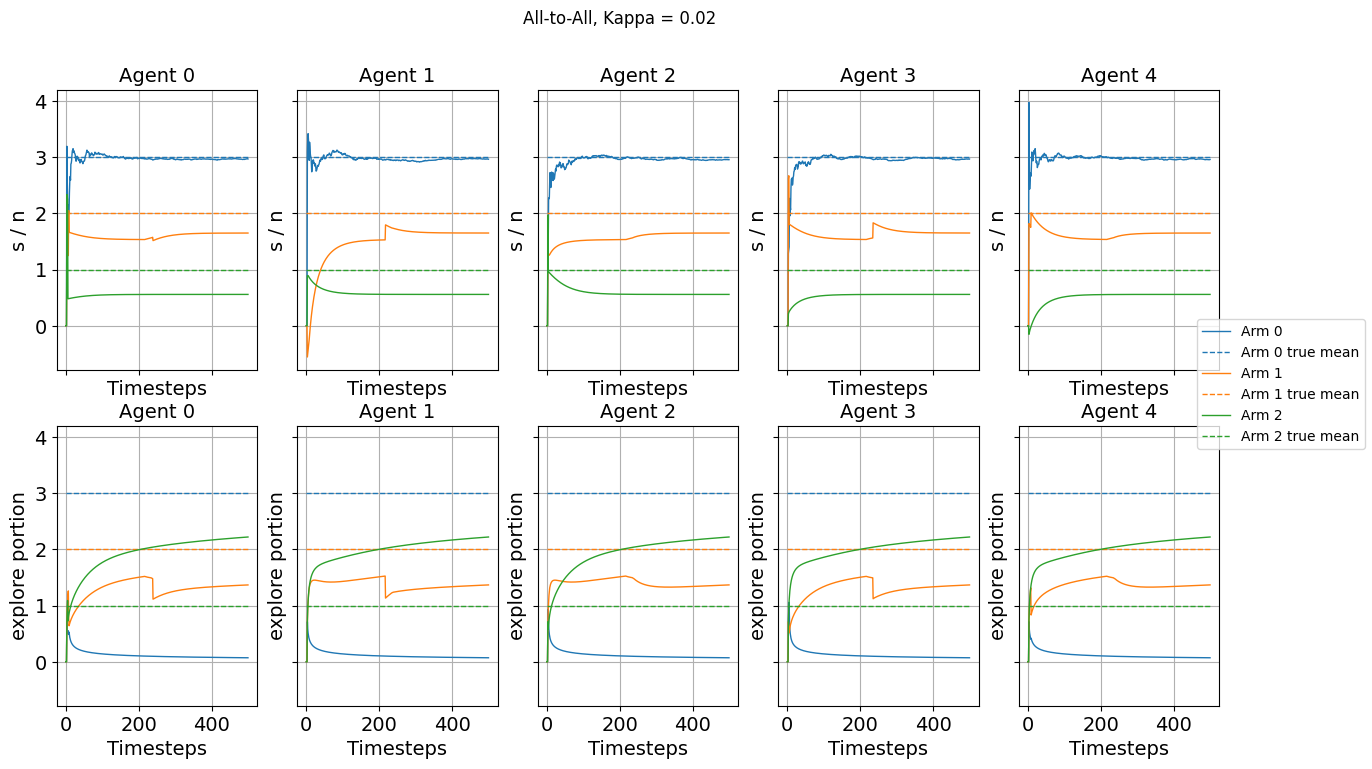

Simulation started at Tue Nov  8 11:27:38 2022
status: optimal
Optimal value: 2.8593117873398913e-08
Variable var514: value [0.19999999 0.19999999 0.19999999 0.19999999 0.19999999 0.19999999
 0.19999999 0.19999999 0.19999999 0.19999999]
[[[493.   5.   2.]
  [493.   5.   2.]
  [493.   5.   2.]
  [493.   5.   2.]
  [493.   5.   2.]]]
Simulation ended at Tue Nov  8 11:27:39 2022


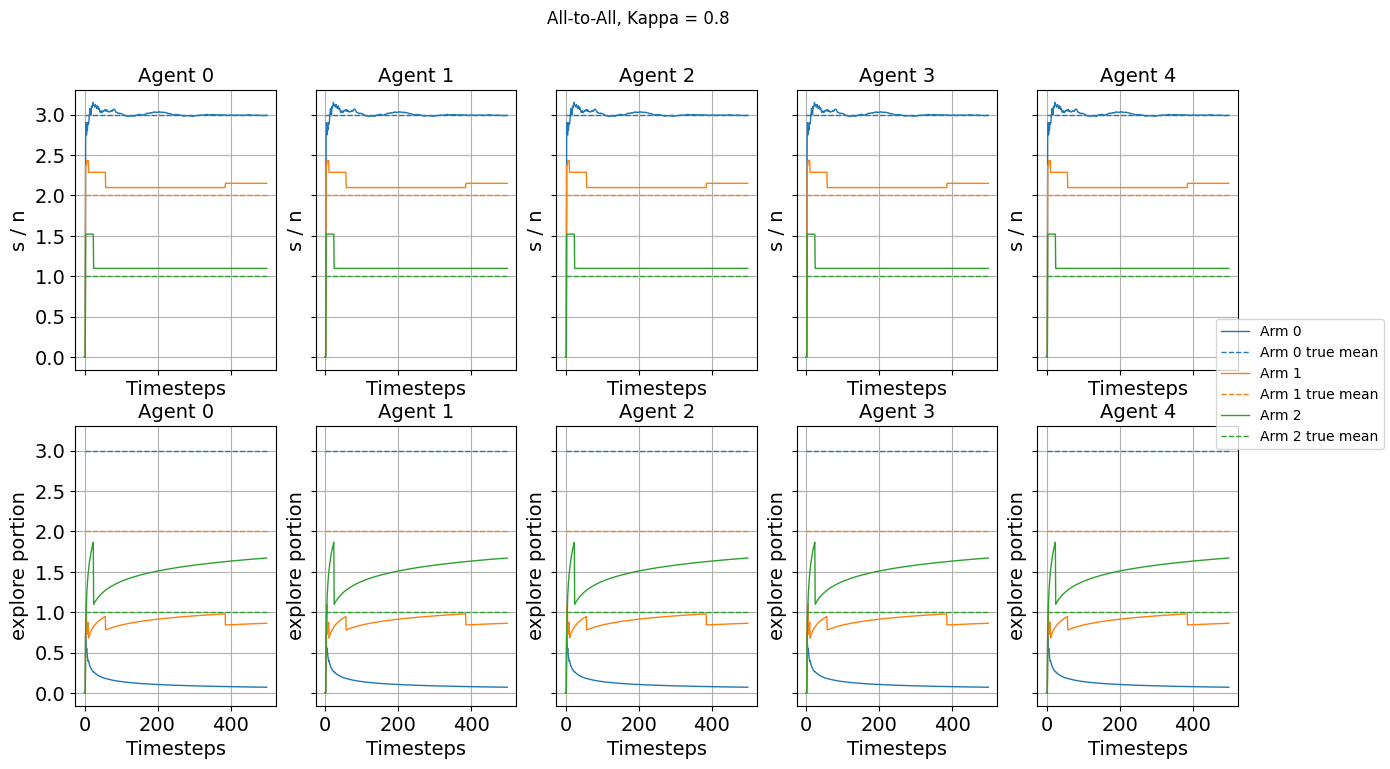

In [67]:
N = 3
runs = 1
T = 500

# adjacency matrices
As = [
	# np.array([
	# 	[0, 1, 1, 1, 0, 0, 0, 0],
	# 	[1, 0, 1, 0, 1, 0, 0, 0],
	# 	[1, 1, 0, 1, 1, 0, 0, 0],
	# 	[1, 0, 1, 0, 1, 1, 1, 1],
	# 	[0, 1, 1, 1, 0, 1, 1, 1],
	# 	[0, 0, 0, 1, 1, 0, 1, 1],
	# 	[0, 0, 0, 1, 1, 1, 0, 1],
	# 	[0, 0, 0, 1, 1, 1, 1, 0],
	# ])
	# np.array([
	# 	[0, 1, 1, 1, 1],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# ])
	np.array([
		[0, 1, 1, 1, 1],
		[1, 0, 1, 1, 1],
		[1, 1, 0, 1, 1],
		[1, 1, 1, 0, 1],
		[1, 1, 1, 1, 0],
	])
]

# corresponding incidence matrices
Is = [
	# np.array([
	# 	[  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
	# 	[ -1,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
	# 	[  0, -1,  0, -1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0],
	# 	[  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
	# 	[  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,  1,  1,  1,  0,  0,  0],
	# 	[  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  1,  1,  0],
	# 	[  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  1],
	# 	[  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1, -1],
	# ])
	# np.array([
	# 	[ 1,  1,  1,  1],
	# 	[-1,  0,  0,  0],
	# 	[ 0, -1,  0,  0],
	# 	[ 0,  0, -1,  0],
	# 	[ 0,  0,  0, -1],
	# ])
	np.array([
		[ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0],
		[-1,  0,  0,  0,  1,  1,  1,  0,  0,  0],
		[ 0, -1,  0,  0, -1,  0,  0,  1,  1,  0],
		[ 0,  0, -1,  0,  0, -1,  0, -1,  0,  1],
		[ 0,  0,  0, -1,  0,  0, -1,  0, -1, -1],
	])
]

kappas = [0.02]
networks = [
	'8-agent network',
]

# trueMeans = np.array([np.random.normal(0, 1, N) for _ in range(runs)])
trueMeans = np.array([[3, 2, 1] for _ in range(runs)])

# sizing
SMALL_SIZE = 10
MEDIUM_SIZE = 14
LARGE_SIZE = 18

# plt.rcParams["figure.figsize"] = (15, 8)
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)

np.set_printoptions(threshold=99999999999999999)

# cm = plt.get_cmap('gist_rainbow')
colors = [
	'tab:blue',
	'tab:orange',
	'tab:green',
	'tab:red',
	'tab:purple',
	'tab:brown',
	'tab:pink',
	'tab:gray',
	'tab:olive',
	'tab:cyan',
]

for kappa in kappas:
	fig, axss = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 8))
	fig.suptitle(f'All-to-All, Kappa = {kappa}')
	axs0 = axss[0].flatten()
	axs1 = axss[1].flatten()

	print(f'Simulation started at {ctime(time())}')

	P = generateP(As[0], kappa=kappa)
	# _, P, _ = fdla_weights_symmetric(Is[0])

	_, Q, sn, expl = run(runs, N, T, trueMeans, P)

	Q = np.mean(Q, axis=0)
	sn = np.mean(sn, axis=0)
	expl = np.mean(expl, axis=0)

	for i, (axUp, axDown) in enumerate(zip(axs0, axs1)):
		# ax.set_prop_cycle(color=[cm(1.*j/10) for j in range(10)])
		axUp.grid(True)
		axUp.set_title(f'Agent {i}')
		axUp.set_xlabel('Timesteps')
		axUp.set_ylabel('s / n')

		axDown.grid(True)
		axDown.set_title(f'Agent {i}')
		axDown.set_xlabel('Timesteps')
		axDown.set_ylabel('explore portion')

		for n in range(N):
			axUp.plot(sn[i, n, :], label=f'Arm {n}', lw=1, linestyle='solid', color=colors[n])
			axUp.plot([trueMeans[0][n] for _ in range(T)], label=f'Arm {n} true mean', lw=1, linestyle='dashed', color=colors[n])

			axDown.plot(expl[i, n, :], label=f'Arm {n}', lw=1, linestyle='solid', color=colors[n])
			axDown.plot([trueMeans[0][n] for _ in range(T)], label=f'Arm {n} true mean', lw=1, linestyle='dashed', color=colors[n])
		# ax.legend()

	handles, labels = axs0[0].get_legend_handles_labels()
	fig.legend(handles, labels, loc='right')

	print(f'Simulation ended at {ctime(time())}')
	plt.show()


N = 3
runs = 1
T = 500

# adjacency matrices
As = [
	# np.array([
	# 	[0, 1, 1, 1, 0, 0, 0, 0],
	# 	[1, 0, 1, 0, 1, 0, 0, 0],
	# 	[1, 1, 0, 1, 1, 0, 0, 0],
	# 	[1, 0, 1, 0, 1, 1, 1, 1],
	# 	[0, 1, 1, 1, 0, 1, 1, 1],
	# 	[0, 0, 0, 1, 1, 0, 1, 1],
	# 	[0, 0, 0, 1, 1, 1, 0, 1],
	# 	[0, 0, 0, 1, 1, 1, 1, 0],
	# ])
	# np.array([
	# 	[0, 1, 1, 1, 1],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# 	[1, 0, 0, 0, 0],
	# ])
	np.array([
		[0, 1, 1, 1, 1],
		[1, 0, 1, 1, 1],
		[1, 1, 0, 1, 1],
		[1, 1, 1, 0, 1],
		[1, 1, 1, 1, 0],
	])
]

# corresponding incidence matrices
Is = [
	# np.array([
	# 	[  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
	# 	[ -1,  0,  0,  1,  1,  1,  1,  1,  0,  0,  0,  0,  0,  0,  0,  0,  0],
	# 	[  0, -1,  0, -1,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0,  0,  0],
	# 	[  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  1,  0,  0,  0,  0,  0,  0],
	# 	[  0,  0,  0,  0, -1,  0,  0,  0,  0, -1, -1,  1,  1,  1,  0,  0,  0],
	# 	[  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0,  0,  1,  1,  0],
	# 	[  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1,  0,  1],
	# 	[  0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0, -1,  0, -1, -1],
	# ])
	# np.array([
	# 	[ 1,  1,  1,  1],
	# 	[-1,  0,  0,  0],
	# 	[ 0, -1,  0,  0],
	# 	[ 0,  0, -1,  0],
	# 	[ 0,  0,  0, -1],
	# ])
	np.array([
		[ 1,  1,  1,  1,  0,  0,  0,  0,  0,  0],
		[-1,  0,  0,  0,  1,  1,  1,  0,  0,  0],
		[ 0, -1,  0,  0, -1,  0,  0,  1,  1,  0],
		[ 0,  0, -1,  0,  0, -1,  0, -1,  0,  1],
		[ 0,  0,  0, -1,  0,  0, -1,  0, -1, -1],
	])
]

kappas = [0.8]
networks = [
	'8-agent network',
]

# trueMeans = np.array([np.random.normal(0, 1, N) for _ in range(runs)])
trueMeans = np.array([[3, 2, 1] for _ in range(runs)])

# sizing
SMALL_SIZE = 10
MEDIUM_SIZE = 14
LARGE_SIZE = 18

# plt.rcParams["figure.figsize"] = (15, 8)
plt.rc('font', size=SMALL_SIZE)
plt.rc('axes', titlesize=MEDIUM_SIZE, labelsize=MEDIUM_SIZE)
plt.rc('xtick', labelsize=MEDIUM_SIZE)
plt.rc('ytick', labelsize=MEDIUM_SIZE)

np.set_printoptions(threshold=99999999999999999)

# cm = plt.get_cmap('gist_rainbow')
colors = [
	'tab:blue',
	'tab:orange',
	'tab:green',
	'tab:red',
	'tab:purple',
	'tab:brown',
	'tab:pink',
	'tab:gray',
	'tab:olive',
	'tab:cyan',
]

for kappa in kappas:
	fig, axss = plt.subplots(2, 5, sharex=True, sharey=True, figsize=(15, 8))
	fig.suptitle(f'All-to-All, Kappa = {kappa}')
	axs0 = axss[0].flatten()
	axs1 = axss[1].flatten()

	print(f'Simulation started at {ctime(time())}')

	# P = generateP(As[0], kappa=kappa)
	_, P, _ = fdla_weights_symmetric(Is[0])

	_, Q, sn, expl = run(runs, N, T, trueMeans, P)

	Q = np.mean(Q, axis=0)
	sn = np.mean(sn, axis=0)
	expl = np.mean(expl, axis=0)

	for i, (axUp, axDown) in enumerate(zip(axs0, axs1)):
		# ax.set_prop_cycle(color=[cm(1.*j/10) for j in range(10)])
		axUp.grid(True)
		axUp.set_title(f'Agent {i}')
		axUp.set_xlabel('Timesteps')
		axUp.set_ylabel('s / n')

		axDown.grid(True)
		axDown.set_title(f'Agent {i}')
		axDown.set_xlabel('Timesteps')
		axDown.set_ylabel('explore portion')

		for n in range(N):
			axUp.plot(sn[i, n, :], label=f'Arm {n}', lw=1, linestyle='solid', color=colors[n])
			axUp.plot([trueMeans[0][n] for _ in range(T)], label=f'Arm {n} true mean', lw=1, linestyle='dashed', color=colors[n])

			axDown.plot(expl[i, n, :], label=f'Arm {n}', lw=1, linestyle='solid', color=colors[n])
			axDown.plot([trueMeans[0][n] for _ in range(T)], label=f'Arm {n} true mean', lw=1, linestyle='dashed', color=colors[n])
		# ax.legend()

	handles, labels = axs0[0].get_legend_handles_labels()
	fig.legend(handles, labels, loc='right')

	print(f'Simulation ended at {ctime(time())}')
	plt.show()